# what logistic regression models

when the outcome is binary $Y \in \{0,1\}$, logistic regression models the probability $p(x) = P(Y=1 \mid X=x)$ through the logit link:
$$
\text{logit}(p) = \log\left(\frac{p}{1 - p}\right) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k
$$

equivalently,
$$
p(x) = \frac{1}{1 + \exp\left(-(\beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k)\right)}
$$

wach coefficient $\beta_j$ represents a change in the log odds for a one unit increase in $x_j$, holding other predictors fixed. The odds ratio for $x_j$ is $\exp(\beta_j)$

Estimation is by maximum likelihood. In practice you call `glm(..., family = binomial)` and R handles optimization

In [1]:
data = mtcars
#response/target/dependent must be coded 0/1 (boolean/binary) 
#in mtcars, am is 0 = automatic, 1 = manual
table(data$am)

# fit logistic regression with binomial family (logit link by default)
fit = glm(am ~ wt + hp, data = data, family = binomial)

summary(fit)


 0  1 
19 13 


Call:
glm(formula = am ~ wt + hp, family = binomial, data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) 18.86630    7.44356   2.535  0.01126 * 
wt          -8.08348    3.06868  -2.634  0.00843 **
hp           0.03626    0.01773   2.044  0.04091 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43.230  on 31  degrees of freedom
Residual deviance: 10.059  on 29  degrees of freedom
AIC: 16.059

Number of Fisher Scoring iterations: 8


In [2]:
#coefficients are on the log odds scale
#negative coefficient means lower odds of `am = 1` as the predictor increases
#positive coefficient means higher odds
#convert to odds ratios for easier interpretation:
coef_table = cbind(Estimate = coef(fit),
                   OddsRatio = exp(coef(fit)))
round(coef_table, 3)

,Estimate,OddsRatio
(Intercept),18.866,1.561455e+08
wt,-8.083,0.000000e+00
hp,0.036,1.037000e+00


In [4]:
p_hat = predict(fit, type = "response")
p_hat

Mazda RX4       Mazda RX4 Wag          Datsun 710      Hornet 4 Drive 
       8.423355e-01        4.047825e-01        9.702408e-01        4.172803e-02 
  Hornet Sportabout             Valiant          Duster 360           Merc 240D 
       6.938812e-02        4.988159e-03        2.480412e-01        9.265579e-03 
           Merc 230            Merc 280           Merc 280C          Merc 450SE 
       4.099813e-02        1.119071e-02        1.119071e-02        5.486846e-04 
         Merc 450SL         Merc 450SLC  Cadillac Fleetwood Lincoln Continental 
       8.500812e-03        5.690614e-03        9.787752e-08        3.445824e-08 
  Chrysler Imperial            Fiat 128         Honda Civic      Toyota Corolla 
       1.124127e-07        9.699832e-01        9.995459e-01        9.983241e-01 
      Toyota Corona    Dodge Challenger         AMC Javelin          Camaro Z28 
       9.210955e-01        1.553207e-02        3.041008e-02        3.585962e-02 
   Pontiac Firebird           Fiat X1-9       Porsche 914-2        Lotus Europa 
       2.815112e-03        9.963800e-01        9.923618e-01        9.999782e-01 
     Ford Pantera L        Ferrari Dino       Maserati Bora          Volvo 142E 
       9.433828e-01        9.437365e-01        8.960342e-01        5.856710e-01

In [9]:
#predict(..., type = "response")` get predicted probabilities 
#p_i choose a threshold to classify (related to ROC curves)

# predicted probabilities
p_hat = predict(fit, type = "response")

# classify using threshold 0.5
y_hat = ifelse(p_hat >= 0.5, 1, 0)

# confusion matrix and simple metrics
conf_mat = table(Actual = data$am, Predicted = y_hat)
conf_mat

accuracy = sum(diag(conf_mat)) / sum(conf_mat)
accuracy

      Predicted
Actual  0  1
     0 18  1
     1  1 12

[1] 0.9375

In [4]:
#compute sensitivity and specificity
tp = conf_mat["1","1"]
tn = conf_mat["0","0"]
fp = conf_mat["0","1"]
fn = conf_mat["1","0"]

sensitivity = tp / (tp + fn)  # recall for class 1
specificity = tn / (tn + fp)
c(accuracy = accuracy, sensitivity = sensitivity, specificity = specificity)

accuracy sensitivity specificity 
  0.9375000   0.9230769   0.9473684

## interpreting coefficients

if $\hat{\beta}_{wt} = -k$, then for a one unit increase in weight (1000 lb in `mtcars`), the odds of a manual transmission are multiplied by $\exp(-k)$. For example, if `exp(-k) = 0.3`, the odds are about 70 percent lower per unit increase in weight, holding `hp` fixed

to interpret a specific increment, like 0.5 units in `wt`, use `exp(beta * 0.5)`

In [10]:
#model fit checks
#overall fit via deviance and pseudo R2:
# null vs residual deviance
fit$null.deviance
fit$deviance

# McFadden pseudo R2 (requires pscl)
# install.packages("pscl")
library(pscl)
pscl::pR2(fit)

[1] 43.22973

[1] 10.05911

Classes and Methods for R originally developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University (2002-2015),
by and under the direction of Simon Jackman.
hurdle and zeroinfl functions by Achim Zeileis.



fitting null model for pseudo-r2


llh     llhNull          G2    McFadden        r2ML        r2CU 
 -5.0295552 -21.6148666  33.1706228   0.7673104   0.6453351   0.8708970

In [11]:
#linearity of the logit for numeric predictors  
#simple, quick check is to add a low-order spline 
#or examine binned residuals
#practical alternative is to add transformed terms and compare models

#example: add a quadratic term for hp and compare
fit2 = glm(am ~ wt + hp + I(hp^2), data = data, family = binomial)
anova(fit, fit2, test = "Chisq")  
# if significant, the extra curvature helps

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,29,10.05911,NA,NA,NA
2,28,10.01049,1,0.04862194,0.8254788


In [12]:
#multicollinearity  
#large collinearity can inflate standard errors
#you can compute VIF on the design matrix as a rough check
library(car)
car::vif(fit)

Loading required package: carData



wt       hp 
2.444297 2.444297

Mazda RX4 Wag Toyota Corona 
            2            21

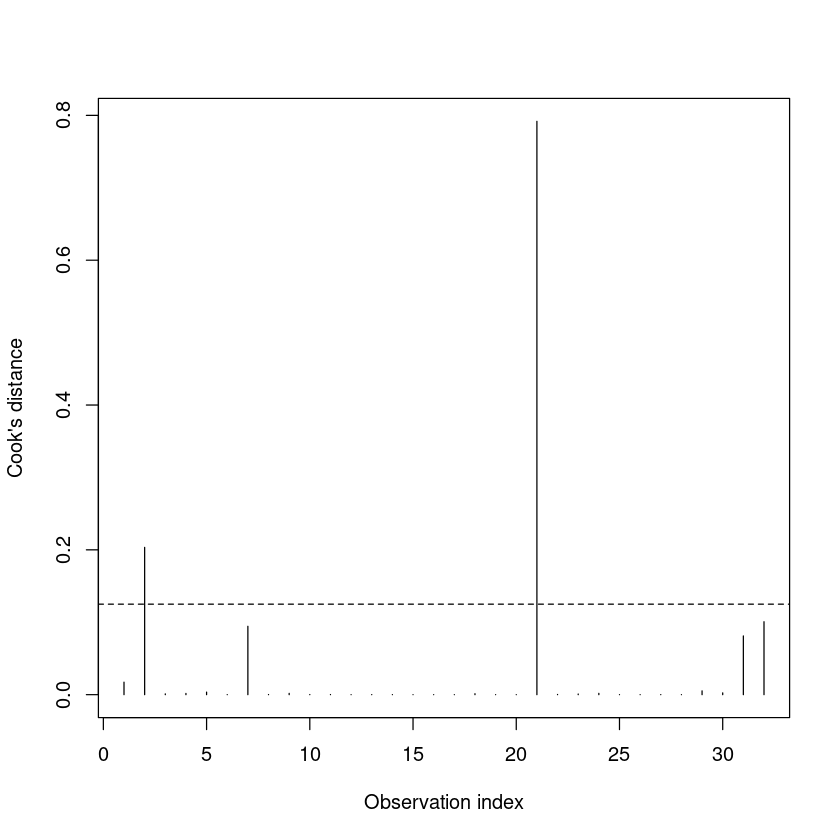

In [13]:
#influential observations  
#cooks distance has a logistic analogue through case deletion diagnostics
#quick view comes from base influence functions

cd = cooks.distance(fit)
plot(cd, type = "h", xlab = "Observation index", ylab = "Cook's distance")
abline(h = 4 / nrow(data), lty = 2)
which(cd > 4 / nrow(data))

In [19]:
data[c(2,21),]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0,1,4,4
Toyota Corona,21.5,4,120.1,97,3.7,2.465,20.01,1,0,3,1


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Area under the curve: 0.9838

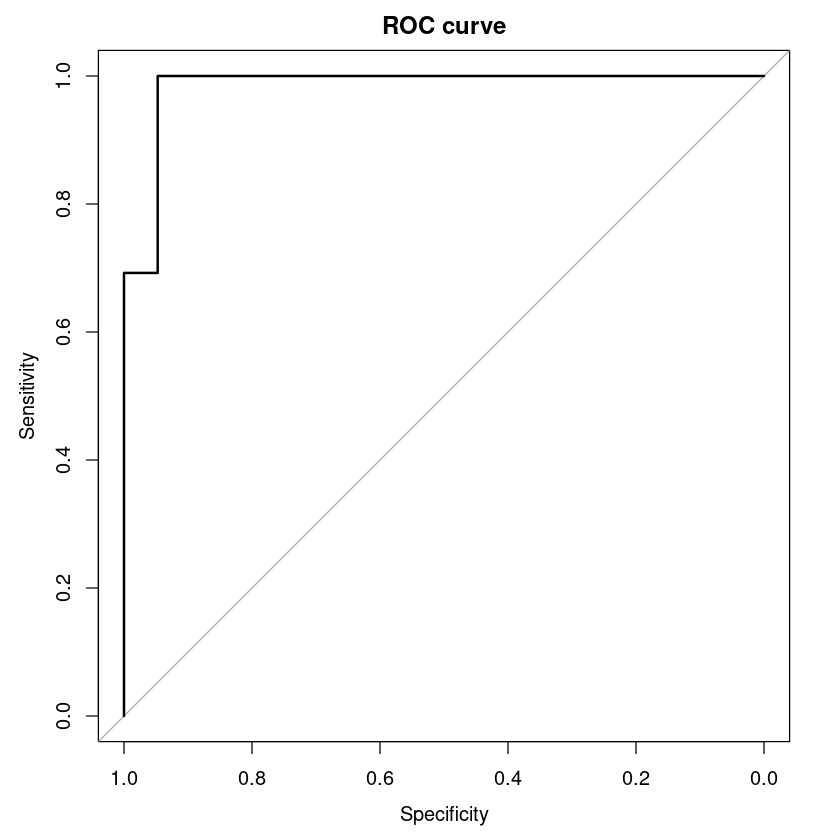

In [11]:
#calibration and discrimination  
#plain ROC curve and AUC using base plotting

library(pROC)

roc_obj = roc(response = data$am, predictor = p_hat, quiet = TRUE)
auc(roc_obj)

plot(roc_obj, main = "ROC curve")

In [12]:
#predicted probabilities by scenario
#helpful to compute probabilities for specific values

new_cars = data.frame(wt = c(2.2, 3.0, 3.8),
                      hp = c(90, 140, 200))
pred_prob = predict(fit, newdata = new_cars, type = "response")
cbind(new_cars, p_manual = round(pred_prob, 3))


,wt,hp,p_manual
,<dbl>,<dbl>,<dbl>
1,2.2,90,0.987
2,3.0,140,0.424
3,3.8,200,0.010



Call:
glm(formula = y ~ x1 + x2, family = binomial, data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) 18.86630    7.44356   2.535  0.01126 * 
x1          -8.08348    3.06868  -2.634  0.00843 **
x2           0.03626    0.01773   2.044  0.04091 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43.230  on 31  degrees of freedom
Residual deviance: 10.059  on 29  degrees of freedom
AIC: 16.059

Number of Fisher Scoring iterations: 8


(Intercept)           x1           x2 
1.561455e+08 3.085967e-04 1.036921e+00

      Predicted
Actual  0  1
     0 18  1
     1  1 12

Area under the curve: 0.9838

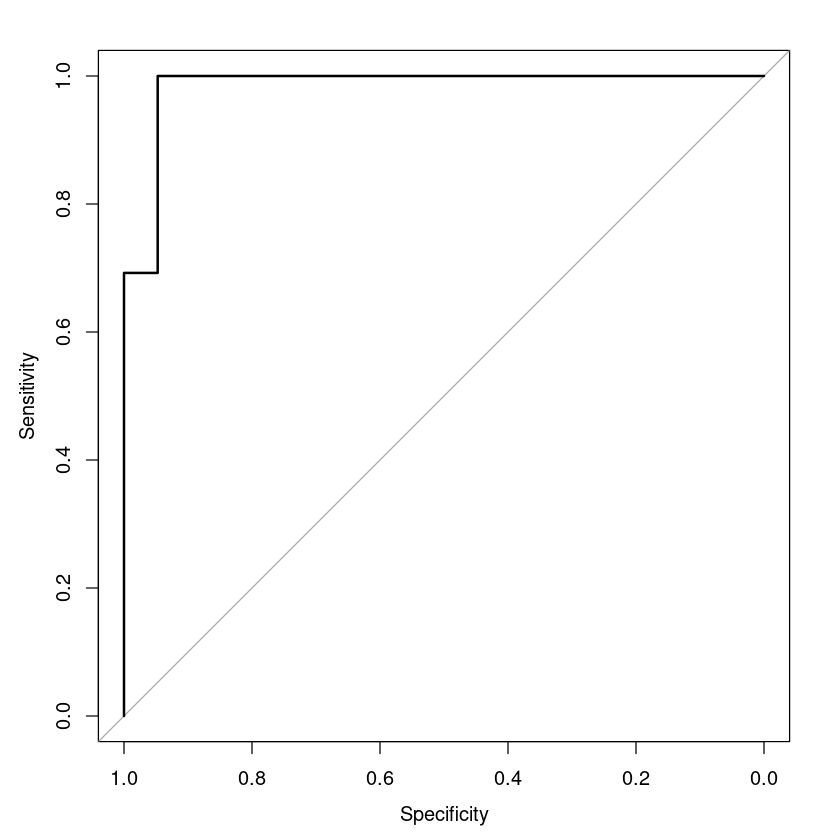

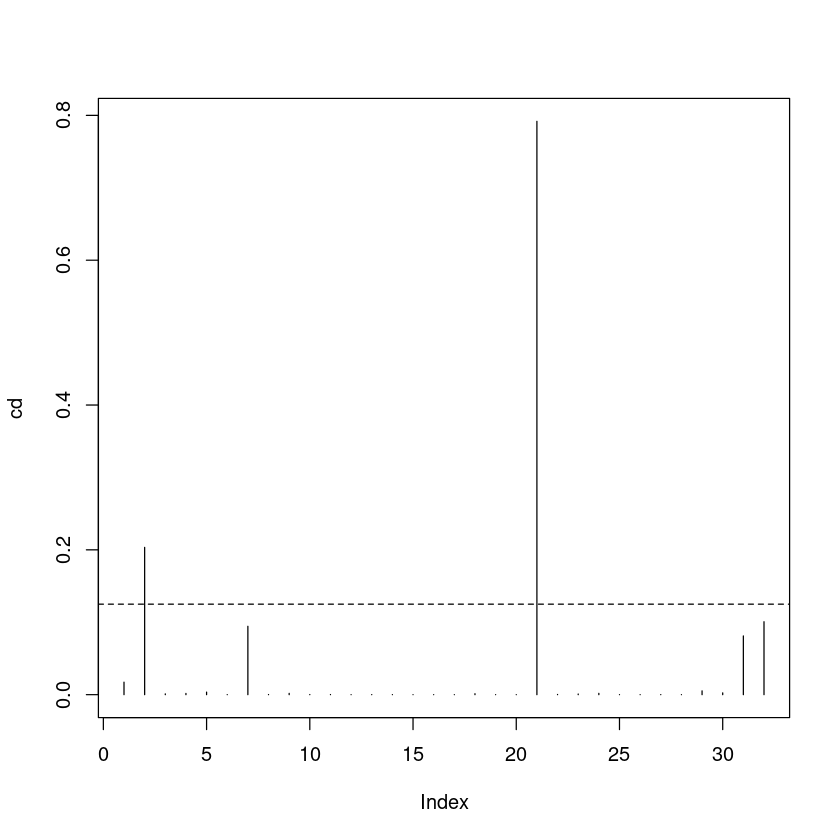

In [15]:
#template, boilerplate
# fit
df = data.frame(
  y  = mtcars$am,   # binary 0/1 already
  x1 = mtcars$wt,   # weight
  x2 = mtcars$hp    # horsepower
)

fit = glm(y ~ x1 + x2, data = df, family = binomial)

# summary and odds ratios
summary(fit)
exp(coef(fit))

# probabilities and classification
p_hat = predict(fit, type = "response")
y_hat = ifelse(p_hat >= 0.5, 1, 0)
table(Actual = df$y, Predicted = y_hat)

# ROC and AUC
library(pROC)
roc_obj = roc(df$y, p_hat, quiet = TRUE)
auc(roc_obj)
plot(roc_obj)

# influence scan
cd = cooks.distance(fit)
plot(cd, type = "h"); abline(h = 4 / nrow(df), lty = 2)


- Logistic regression models log odds as a linear function of predictors and returns class probabilities via the logistic function
- Coefficients are easiest to interpret as odds ratios using `exp(beta)`.
- Validate fit with deviance, pseudo R2, ROC, and simple diagnostics like added curvature terms and influence checks
- When assumptions are strained, use transformations, interaction terms, splines, or regularized and bias-reduced alternatives.


# Log odds 

- probability $p$ is a number between 0 and 1
- odds compare the chance of the event to the chance of no event:
  $$
  \text{odds} = \frac{p}{1 - p}
  $$
- log odds apply the natural logarithm to odds:
  $$
  \text{log\_odds} = \log\left(\frac{p}{1 - p}\right)
  $$

notes
- small probabilities give negative log odds
- $p = 0.5$ gives odds $= 1$ and log odds $= 0$
- large probabilities give positive log odds

---

from probability to odds:
$$
\text{odds} = \frac{p}{1 - p}
$$

from odds to probability:
$$
p = \frac{\text{odds}}{1 + \text{odds}}
$$

from log odds to probability:
$$
p = \frac{1}{1 + e^{-\text{log\_odds}}}.
$$

from probability to log odds:
$$
\text{log\_odds} = \log\left(\frac{p}{1 - p}\right)
$$

---

- $p = 0.20$ -> odds $= 0.20/0.80 = 0.25$ -> log odds $= \log(0.25) \approx -1.386$
- $p = 0.50$ -> odds $= 1$ -> log odds $= 0$
- $p = 0.80$ -> odds $= 0.80/0.20 = 4$ -> log odds $= \log(4) \approx 1.386$

change of 1.0 in log odds multiplies the odds by $e^1 \approx 2.718$

---

logistic regression models the log odds of $Y=1$ as a linear function of predictors:
$$
\text{log\_odds}(Y=1 \mid X) = \beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k
$$

interpretation
- one unit increase in $x_j$ changes the log odds by $\beta_j$
- then, it multiplies the odds by $\exp(\beta_j)$, called the odds ratio


In [16]:
# convert a vector of probabilities to odds and log odds, then back:

# example probabilities
p = c(0.2, 0.5, 0.8)

# probability -> odds -> log odds
odds = p / (1 - p)
log_odds = log(odds)

# back to probability
p_back = 1 / (1 + exp(-log_odds))

cbind(p = p, odds = odds, log_odds = log_odds, p_back = p_back)

p,odds,log_odds,p_back
0.2,0.25,-1.386294,0.2
0.5,1.00,0.000000,0.5
0.8,4.00,1.386294,0.8


In [17]:
#compute log odds from a fitted logistic model 
#convert to probabilities:

# fit example model
fit = glm(am ~ wt + hp, data = mtcars, family = binomial)

# linear predictor is log odds
log_odds_hat = predict(fit, type = "link")

# convert to predicted probabilities
p_hat = 1 / (1 + exp(-log_odds_hat))

head(cbind(log_odds_hat = log_odds_hat, p_hat = p_hat))

,log_odds_hat,p_hat
Mazda RX4,1.6757093,0.842335537
Mazda RX4 Wag,-0.3855769,0.404782533
Datsun 710,3.4844067,0.970240822
Hornet 4 Drive,-3.1339584,0.041728035
Hornet Sportabout,-2.5961266,0.069388122
Valiant,-5.2956878,0.004988159


- do not interpret log odds directly as probabilities. Always convert back if
- Very small or very large probabilities can produce extreme log odds. Check for separation in logistic models.
- Odds ratios $\exp(\beta)$ are multiplicative on the odds, not on the probability scale.

- Odds $= p/(1-p)$, log odds $= \log(p/(1-p))$
- Logistic regression is linear in log odds
- Odds ratios are $\exp(\text{coefficient})$ and multiply odds per unit change in a predictor